In [17]:
import copy
import itertools
import math
import time

import numpy as np
import pandas as pd
import torch
import torchvision
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.optim import Optimizer
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

## Датасет
Возьмем Оксфордский датасет с 37 видами животных — [OxfordIIITPet](https://www.robots.ox.ac.uk/~vgg/data/pets/)

In [18]:
# настройки
IMAGE_SIZE = 128
BATCH_SIZE = 128
VAL_RATIO = 0.2  # доля данных на валидацию
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Трансформации: изменение размера и нормализация
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset_full = datasets.OxfordIIITPet(root='./data', split='trainval',
                                      target_types='category',
                                      transform=transform, download=True)
test_dataset = datasets.OxfordIIITPet(root='./data', split='test',
                                      target_types='category',
                                      transform=transform, download=True)

total_count = len(dataset_full)
val_count = int(total_count * VAL_RATIO)
train_count = total_count - val_count
train_dataset, val_dataset = random_split(dataset_full, [train_count, val_count],
                                          generator=torch.Generator().manual_seed(42))
print(f"Train set: {len(train_dataset)} images")
print(f"Validation set: {len(val_dataset)} images")
print(f"Test set: {len(test_dataset)} images")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

cuda
Train set: 2944 images
Validation set: 736 images
Test set: 3669 images


## FullyConnectedLayer и ReluLayer

In [19]:
class FullyConnectedLayer(nn.Module):
    def __init__(self, input_dim, output_dim, weight_scale=1e-3):
        super(FullyConnectedLayer, self).__init__()
        self.weight = nn.Parameter(weight_scale * torch.randn(input_dim, output_dim))
        self.b = nn.Parameter(torch.zeros(1, output_dim))

    def forward(self, X):
        out = X @ self.weight + self.b
        return out

class ReluLayer(nn.Module):
    def __init__(self):
        super(ReluLayer, self).__init__()

    def forward(self, X):
        out = torch.clamp(X, min=0)
        return out

## Реализация Нейронной сети
с использованием batch нормализации

In [20]:
# Гиперпараметры модели
INPUT_DIM = 3 * IMAGE_SIZE * IMAGE_SIZE  # размерность входа после flatten
HIDDEN_DIM = 128  # размер скрытого слоя
NUM_CLASSES = 37  # количество классов (пород)
USE_BATCHNORM = True


class SimpleNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, use_batchnorm=False):
        super().__init__()
        self.fc1 = FullyConnectedLayer(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim) if use_batchnorm else None
        self.relu = ReluLayer()
        self.fc2 = FullyConnectedLayer(hidden_dim, num_classes)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1.forward(x)
        if self.bn1 is not None:
            x = self.bn1(x)
        x = self.relu.forward(x)
        x = self.fc2.forward(x)
        return x

    def backward(self, dscores, reg=0.0):
        dout_relu, dW2, db2 = self.fc2.backward(dscores, reg)
        dout_fc1 = self.relu.backward(dout_relu)
        dX, dW1, db1 = self.fc1.backward(dout_fc1, reg)

        grads = {
            'W1': dW1,
            'b1': db1,
            'W2': dW2,
            'b2': db2
        }
        return dX, grads


model = SimpleNet(INPUT_DIM, HIDDEN_DIM, NUM_CLASSES, use_batchnorm=USE_BATCHNORM)
model = model.to(device)  # перенос на GPU при наличии
print(model)


SimpleNet(
  (fc1): FullyConnectedLayer()
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReluLayer()
  (fc2): FullyConnectedLayer()
)


## Реализация Adam

In [21]:
class CustomAdam(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super(CustomAdam, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('CustomAdam не поддерживает разреженные градиенты.')
                state = self.state[p]

                # Инициализация состояния
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(p.data, alpha=group['weight_decay'])

                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
                step_size = group['lr'] / bias_correction1

                p.data.addcdiv_(exp_avg, denom, value=-step_size)

        return loss


## CrossEntropyLoss и L2-регуляризация

In [22]:
# Гиперпараметры оптимизации
criterion = nn.CrossEntropyLoss()
WEIGHT_DECAY = 1e-4  # коэффициент L2-регуляризации

## Подбор гиперпараметров
а также проверка корректности вычисления градиентов

In [23]:
def train_one_configuration(lr, optimizer_name, hidden_size, use_bn, num_epochs=5):
    model = SimpleNet(INPUT_DIM, hidden_size, NUM_CLASSES, use_batchnorm=use_bn)
    model = model.to(device)

    if  optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)
    elif optimizer_name == 'Adam':
        optimizer = CustomAdam(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)
    else:
        raise ValueError("Неизвестный оптимизатор!")

    epoch_train_losses = []
    epoch_train_accs   = []
    epoch_val_losses   = []
    epoch_val_accs     = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            # Выполнить проверку градиентов для первого батча каждой эпохи
            if batch_idx == 0:
                model_copy = copy.deepcopy(model).cpu().double()
                X_batch_double = X_batch.cpu().double()
                y_batch_double = y_batch.cpu()

                model_copy.zero_grad()
                output_copy = model_copy(X_batch_double)
                loss_copy = criterion(output_copy, y_batch_double)
                loss_copy.backward()

                analytic_grad = model_copy.fc1.weight.grad[0, 0].item()

                epsilon = 1e-5
                orig_value = model_copy.fc1.weight.data[0, 0].item()

                # Loss при w + epsilon
                model_copy.fc1.weight.data[0, 0] = orig_value + epsilon
                loss_plus = criterion(model_copy(X_batch_double), y_batch_double).item()

                # Loss при w - epsilon
                model_copy.fc1.weight.data[0, 0] = orig_value - epsilon
                loss_minus = criterion(model_copy(X_batch_double), y_batch_double).item()

                numerical_grad = (loss_plus - loss_minus) / (2 * epsilon)
                print(f"Epoch {epoch+1} Batch {batch_idx+1} gradient check for fc1.weight[0,0]: "
                      f"analytic = {analytic_grad:.6f}, numeric = {numerical_grad:.6f}")

            running_loss += loss.item() * X_batch.size(0)
            _, preds = outputs.max(1)
            correct_train += (preds == y_batch).sum().item()
            total_train += X_batch.size(0)

        avg_train_loss = running_loss / total_train
        train_acc = correct_train / total_train
        epoch_train_losses.append(avg_train_loss)
        epoch_train_accs.append(train_acc)

        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                running_val_loss += loss.item() * X_batch.size(0)
                _, preds = outputs.max(1)
                correct_val += (preds == y_batch).sum().item()
                total_val += y_batch.size(0)

        avg_val_loss = running_val_loss / total_val
        val_acc = correct_val / total_val
        epoch_val_losses.append(avg_val_loss)
        epoch_val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}: train_loss = {avg_train_loss:.4f}, train_acc = {train_acc:.4f} | val_loss = {avg_val_loss:.4f}, val_acc = {val_acc:.4f}")

    return {
        'final_val_acc': epoch_val_accs[-1],
        'final_train_loss': epoch_train_losses[-1],
        'epoch_train_losses': epoch_train_losses,
        'epoch_val_losses': epoch_val_losses,
        'epoch_train_accs': epoch_train_accs,
        'epoch_val_accs': epoch_val_accs,
        'model': model
    }

In [24]:
lr_list = [1e-2, 1e-3, 1e-4]
optimizers_list = ['Adam', 'RMSprop']
hidden_sizes = [64, 128, 256]
batchnorm_flags = [True, False]

num_epochs_tune = 10

results = []
best_config = None
best_val_acc = 0

total_combinations = len(lr_list) * len(optimizers_list) * len(hidden_sizes) * len(batchnorm_flags)
counter = 0

for lr, opt_name, hidden_size, use_bn in itertools.product(lr_list, optimizers_list, hidden_sizes, batchnorm_flags):
    counter += 1
    print(f"\nКомбинация {counter}/{total_combinations}: lr={lr}, оптимизатор={opt_name}, скрытый размер={hidden_size}, batchnorm={use_bn}")
    start_time = time.time()
    metrics = train_one_configuration(lr, opt_name, hidden_size, use_bn, num_epochs=num_epochs_tune)
    elapsed_time = time.time() - start_time
    results.append({
        'lr': lr,
        'optimizer': opt_name,
        'hidden_size': hidden_size,
        'batchnorm': use_bn,
        'final_val_acc': metrics['final_val_acc'],
        'final_train_loss': metrics['final_train_loss'],
        'epoch_train_losses': metrics['epoch_train_losses'],
        'epoch_val_losses': metrics['epoch_val_losses'],
        'time_sec': elapsed_time
    })
    print(f"Validation accuracy: {metrics['final_val_acc']:.4f}, Final train loss: {metrics['final_train_loss']:.4f} (время: {elapsed_time:.2f} сек)")
    if metrics['final_val_acc'] > best_val_acc:
        best_val_acc = metrics['final_val_acc']
        best_config = (lr, opt_name, hidden_size, use_bn)

print("\nЛучшие гиперпараметры:")
print(f"lr = {best_config[0]}, оптимизатор = {best_config[1]}, скрытый размер = {best_config[2]}, batchnorm = {best_config[3]}")
print(f"Лучшее значение validation accuracy = {best_val_acc:.4f}")


Комбинация 1/36: lr=0.01, оптимизатор=Adam, скрытый размер=64, batchnorm=True
Epoch 1 Batch 1 gradient check for fc1.weight[0,0]: analytic = 0.000010, numeric = 0.000010
Epoch 1/10: train_loss = 3.5147, train_acc = 0.0530 | val_loss = 3.3307, val_acc = 0.0938
Epoch 2 Batch 1 gradient check for fc1.weight[0,0]: analytic = 0.000001, numeric = 0.000001
Epoch 2/10: train_loss = 3.3213, train_acc = 0.0924 | val_loss = 3.2252, val_acc = 0.1281
Epoch 3 Batch 1 gradient check for fc1.weight[0,0]: analytic = 0.000007, numeric = 0.000007
Epoch 3/10: train_loss = 3.2167, train_acc = 0.1206 | val_loss = 3.0876, val_acc = 0.1600
Epoch 4 Batch 1 gradient check for fc1.weight[0,0]: analytic = 0.000003, numeric = 0.000003
Epoch 4/10: train_loss = 3.1092, train_acc = 0.1495 | val_loss = 3.0091, val_acc = 0.1827
Epoch 5 Batch 1 gradient check for fc1.weight[0,0]: analytic = 0.000172, numeric = 0.000172
Epoch 5/10: train_loss = 3.0525, train_acc = 0.1512 | val_loss = 2.8711, val_acc = 0.2137
Epoch 6 Bat

## Графики

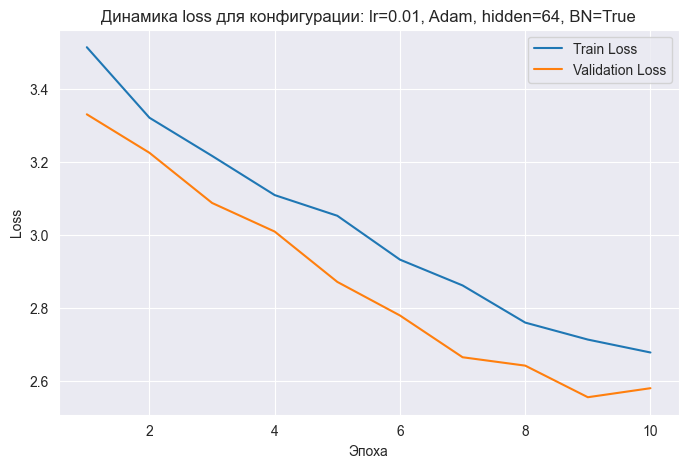

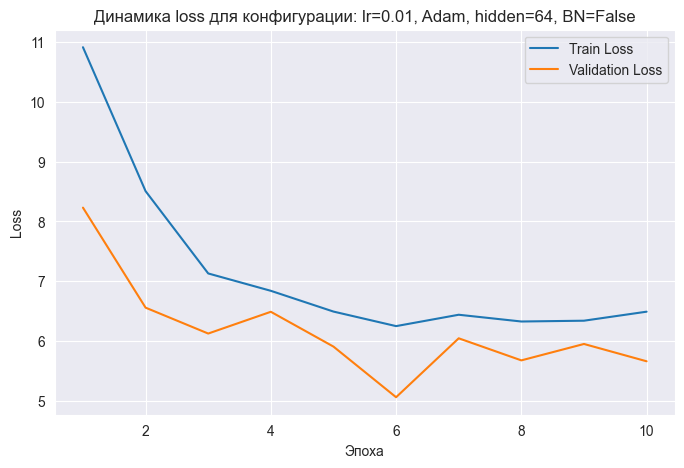

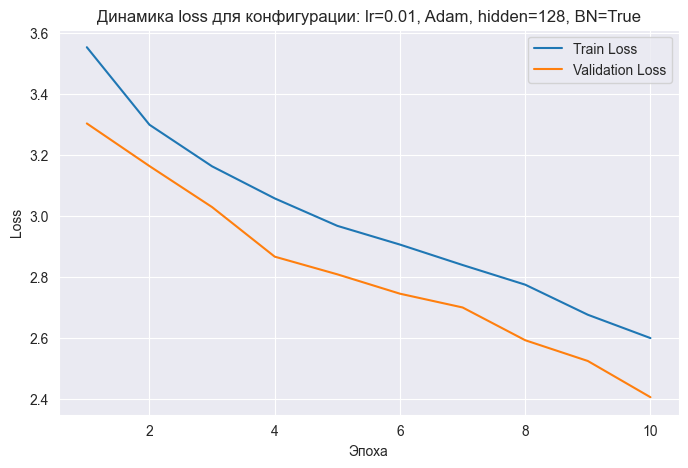

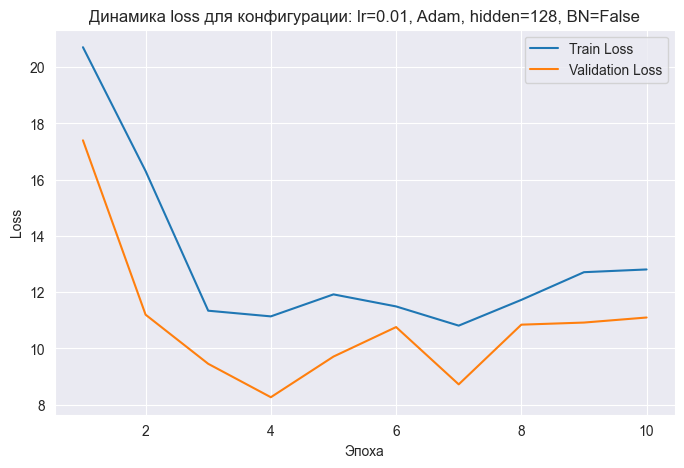

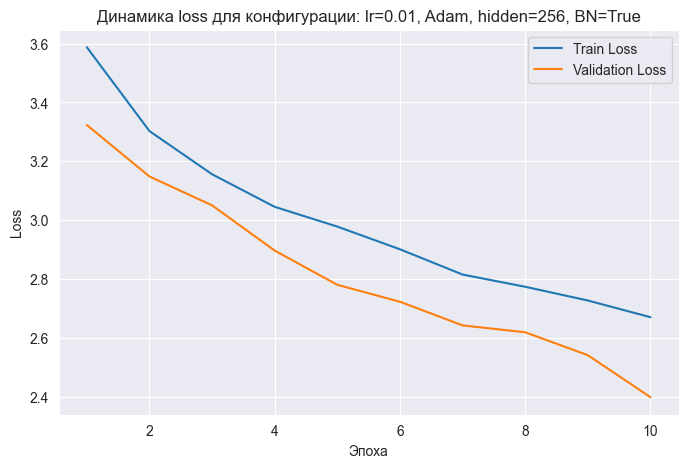

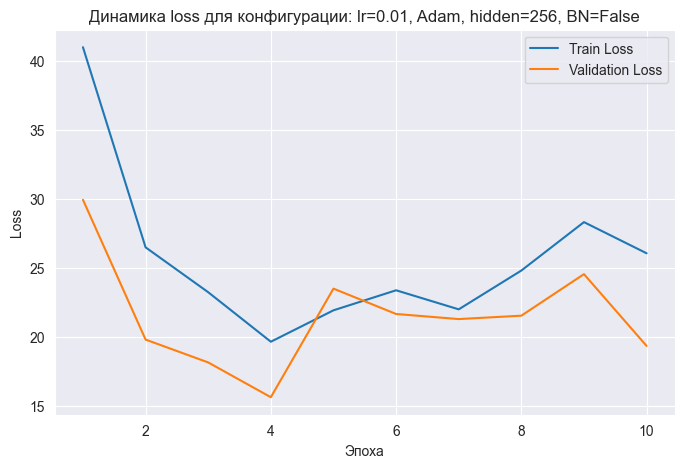

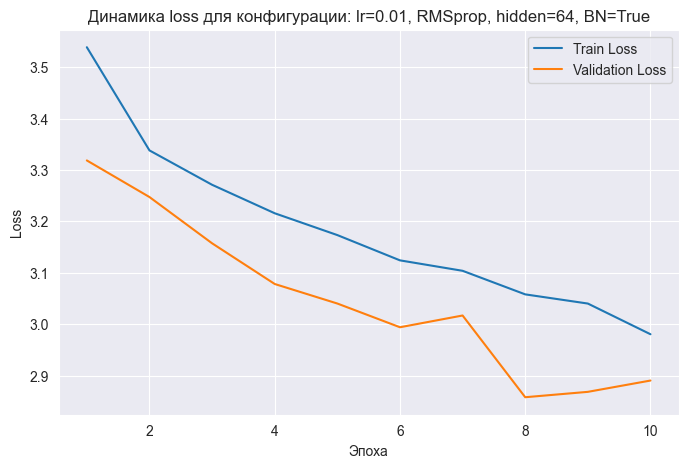

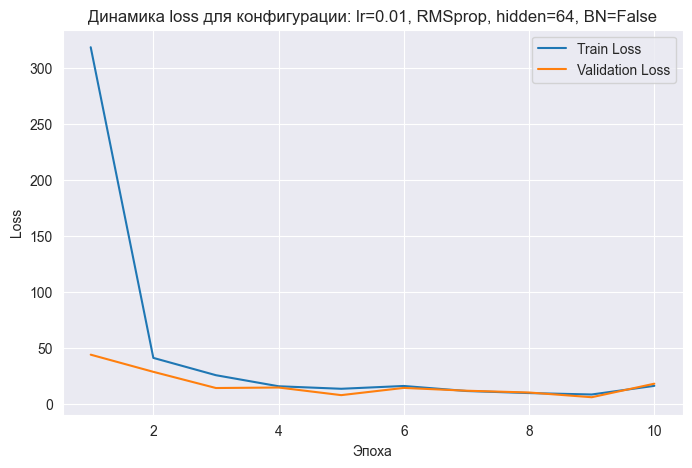

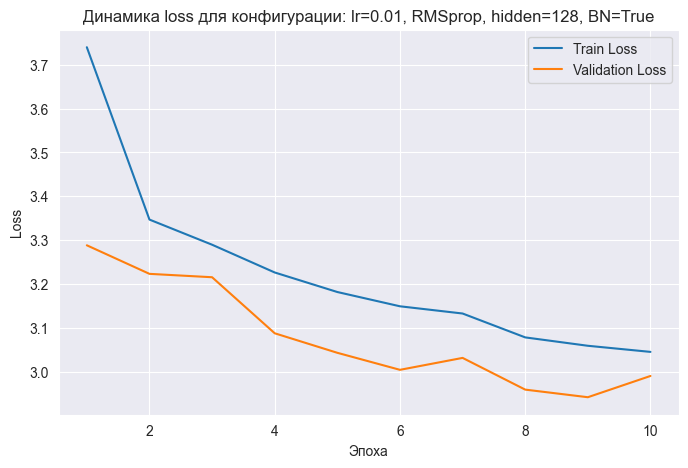

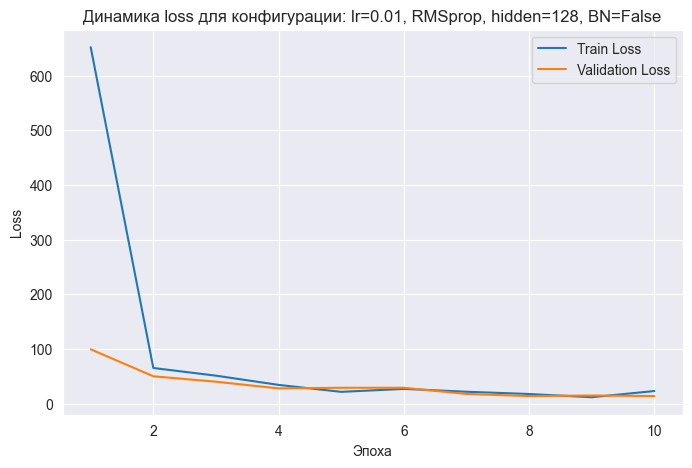

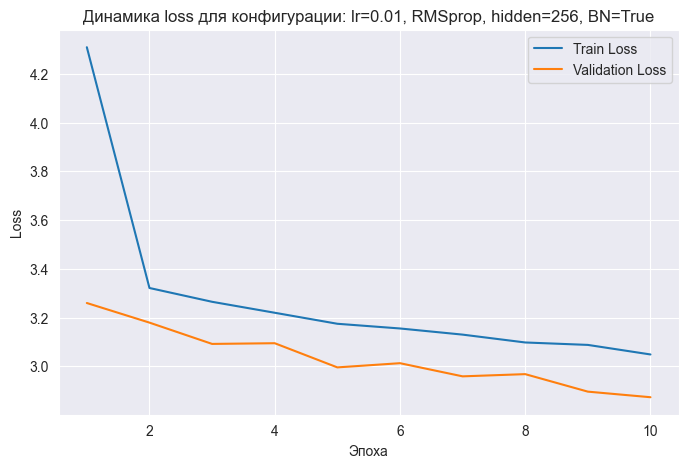

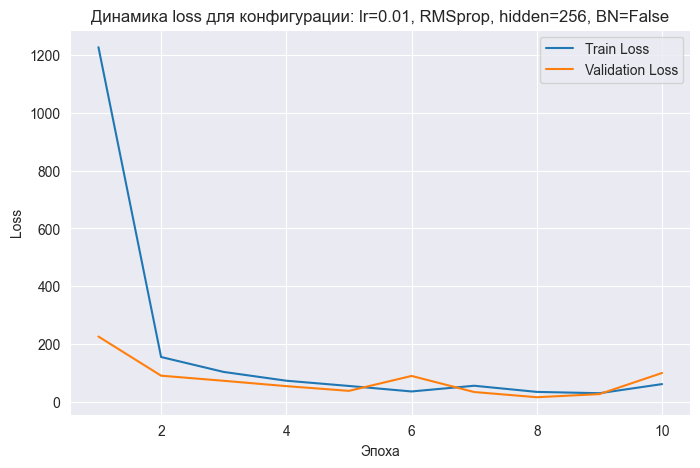

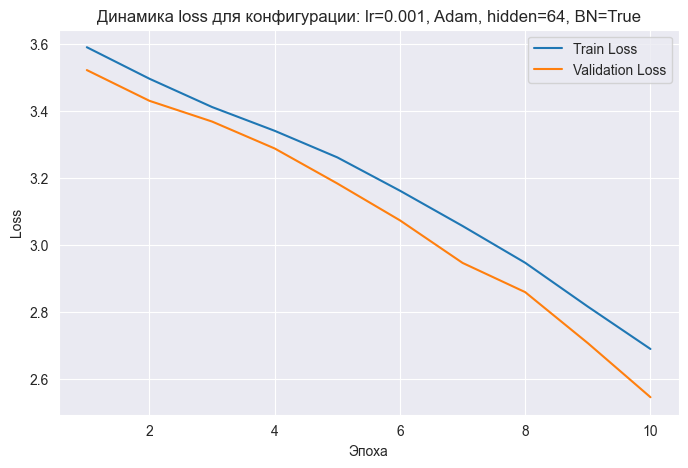

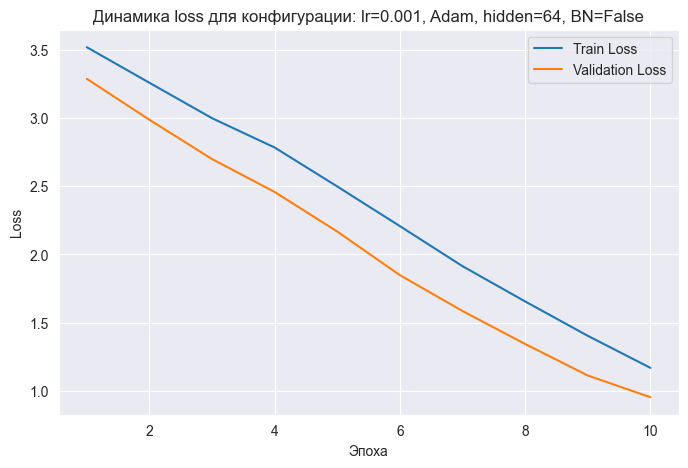

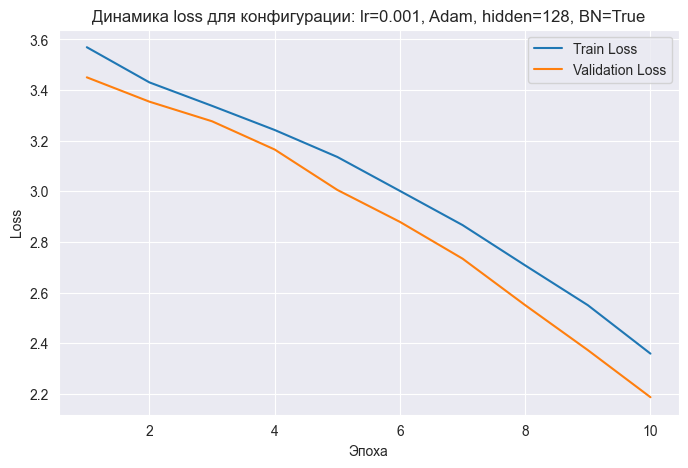

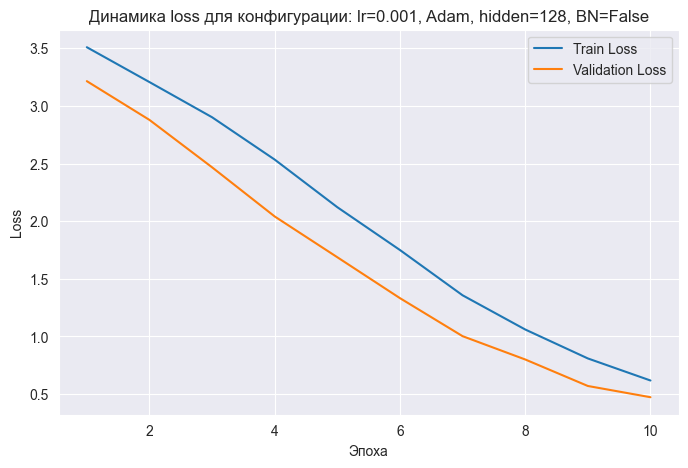

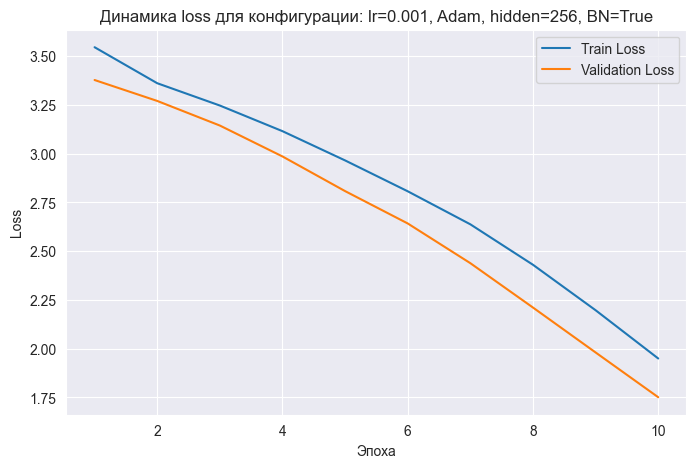

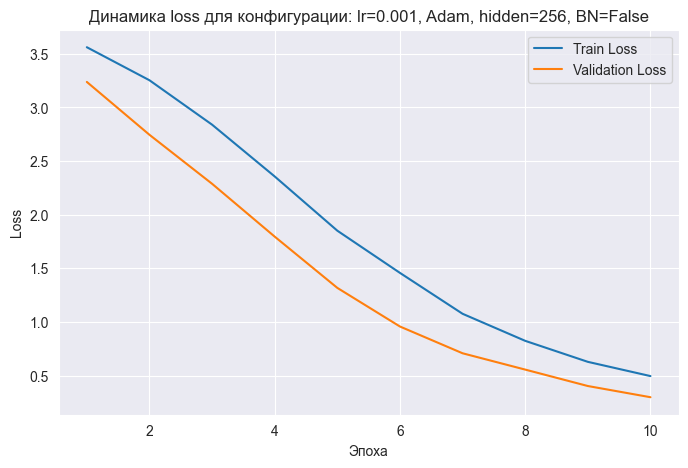

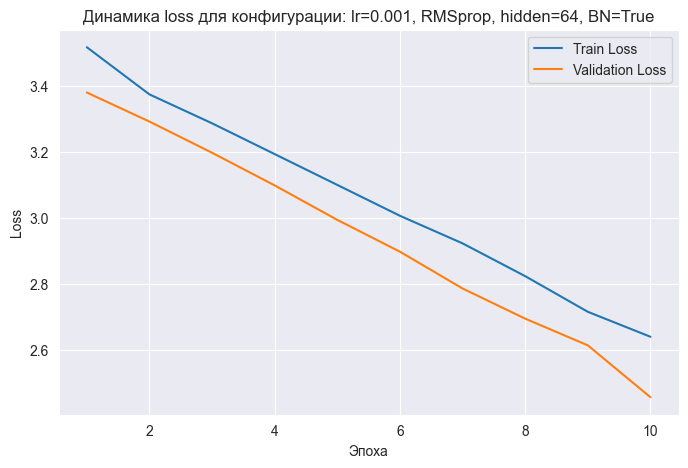

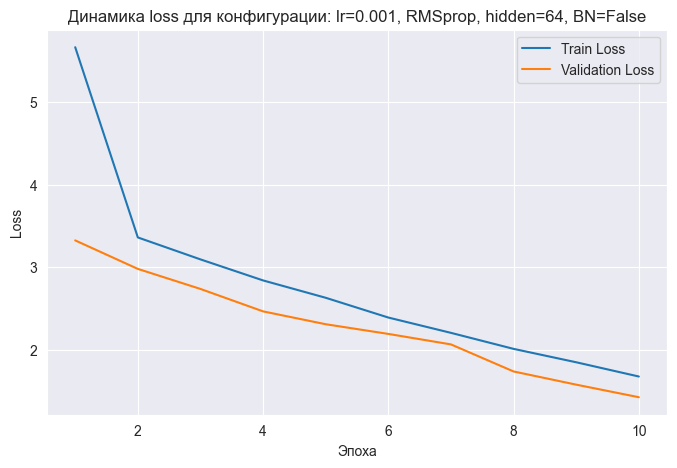

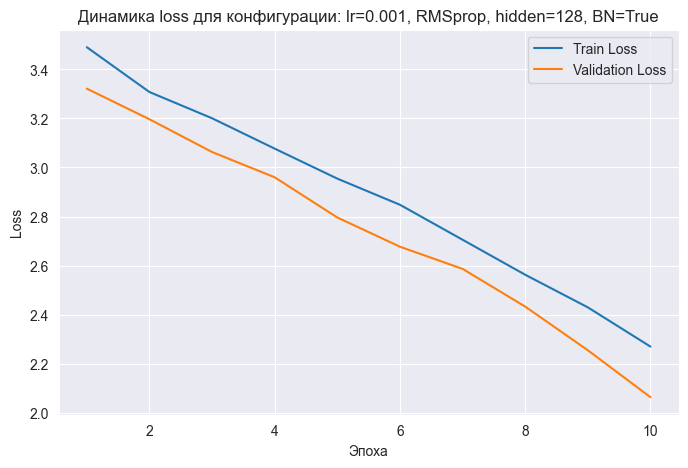

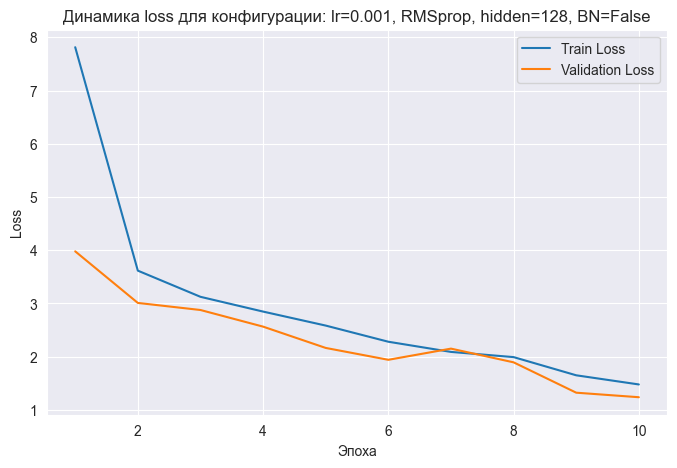

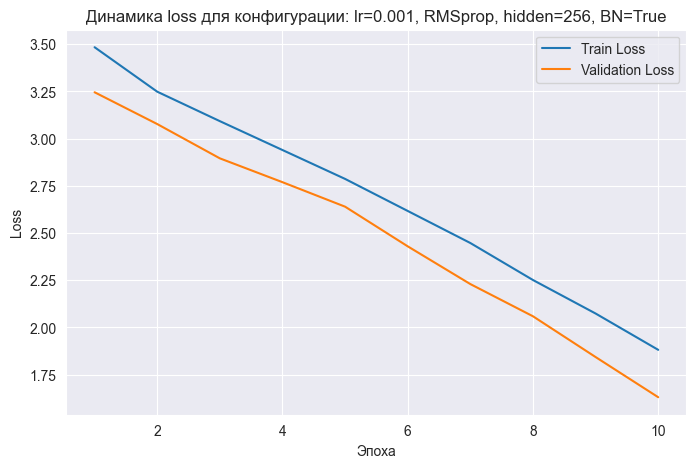

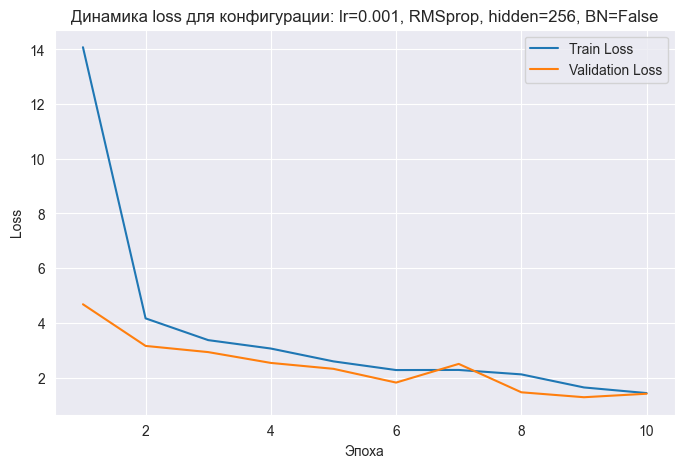

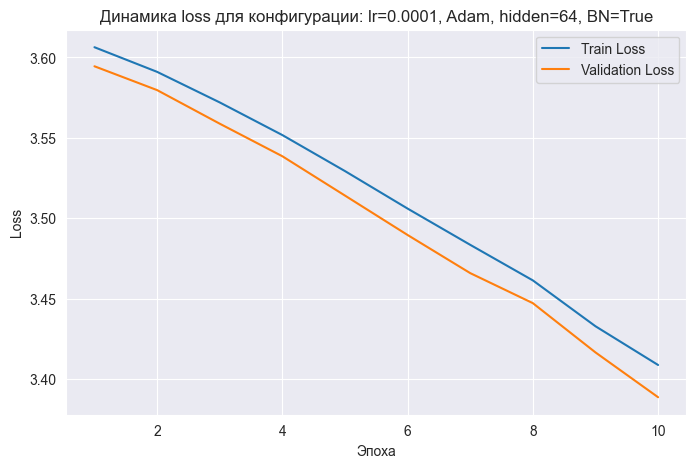

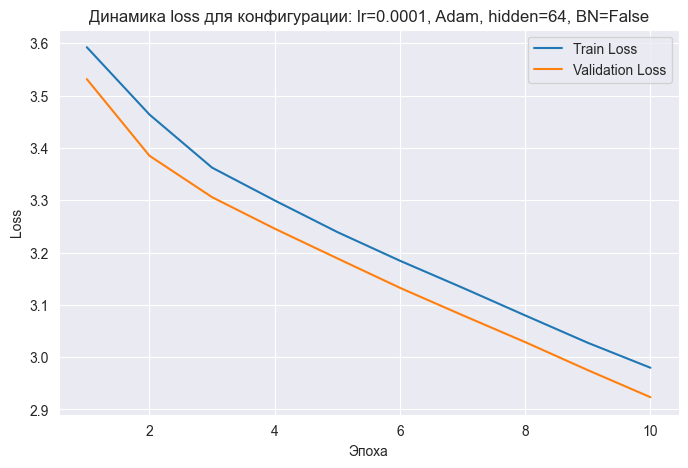

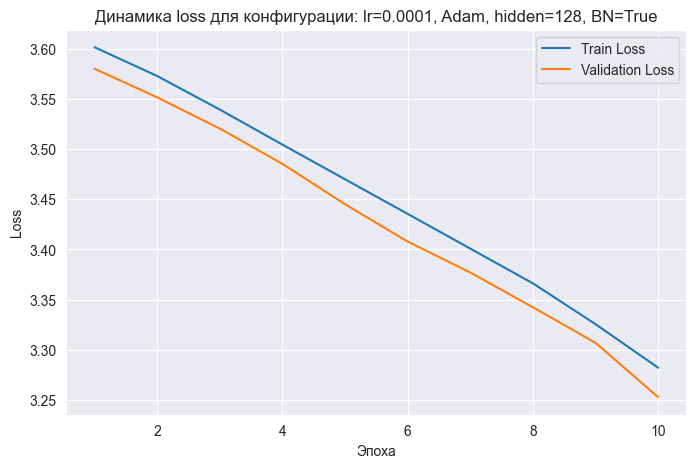

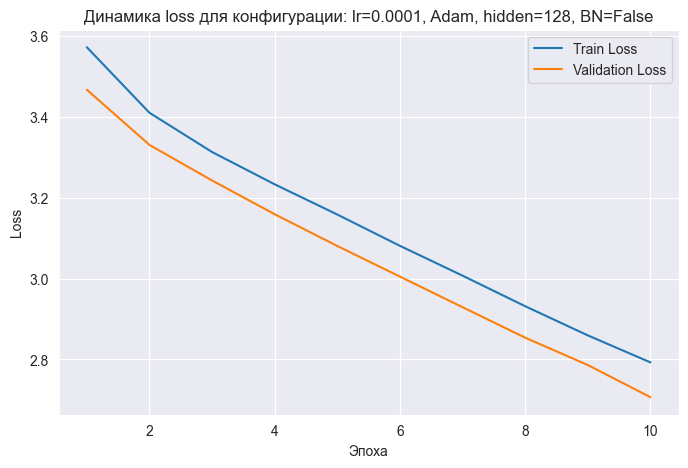

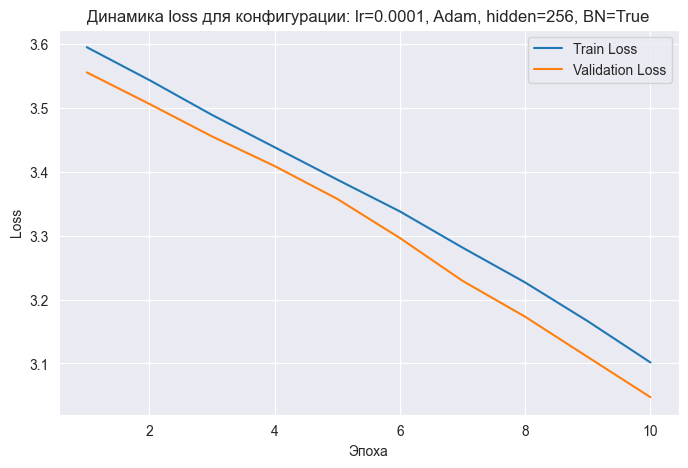

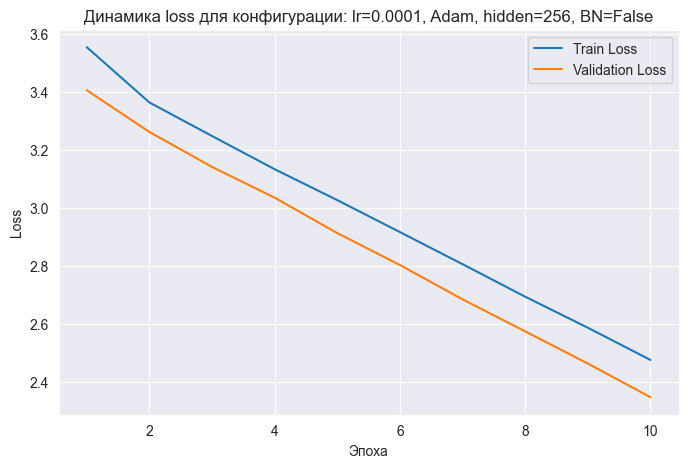

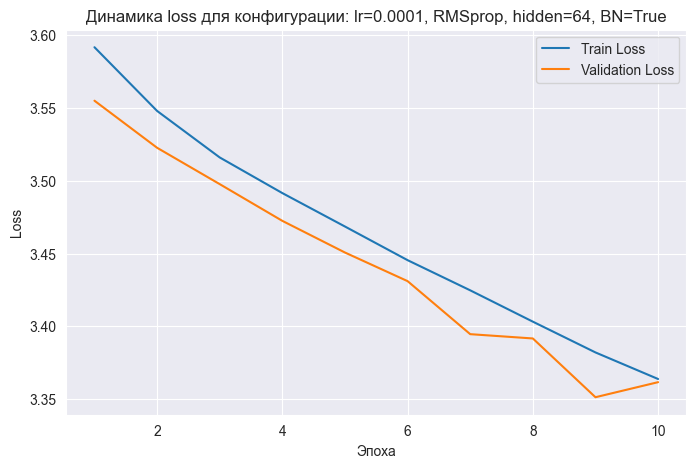

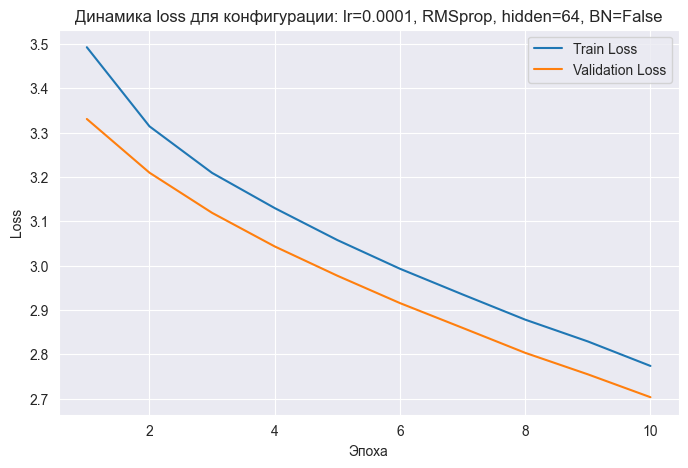

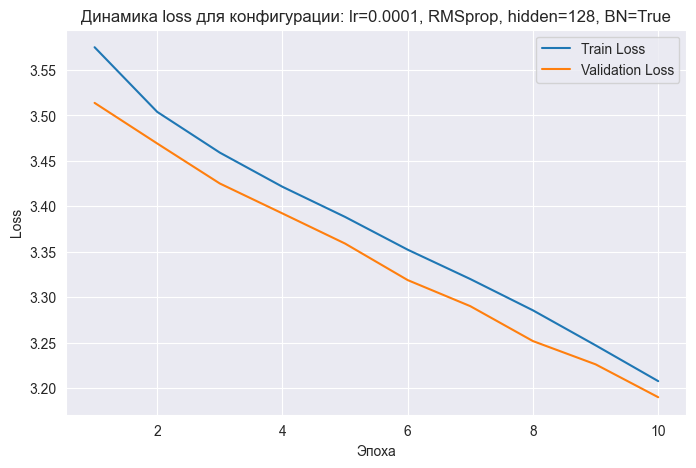

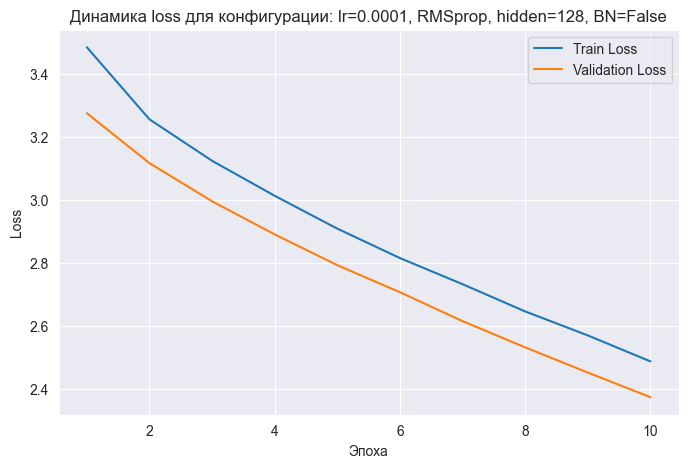

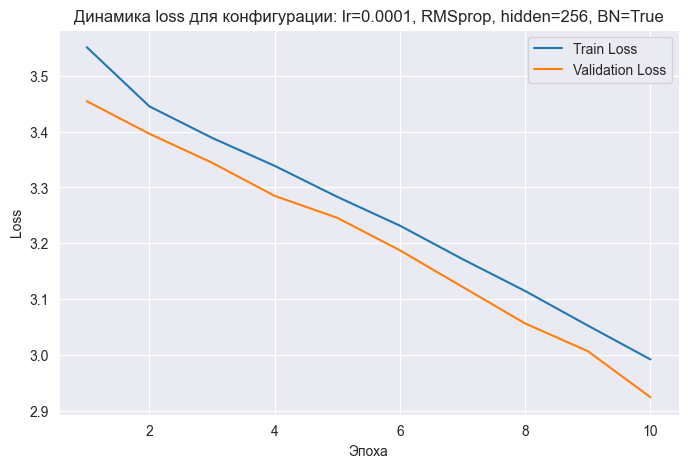

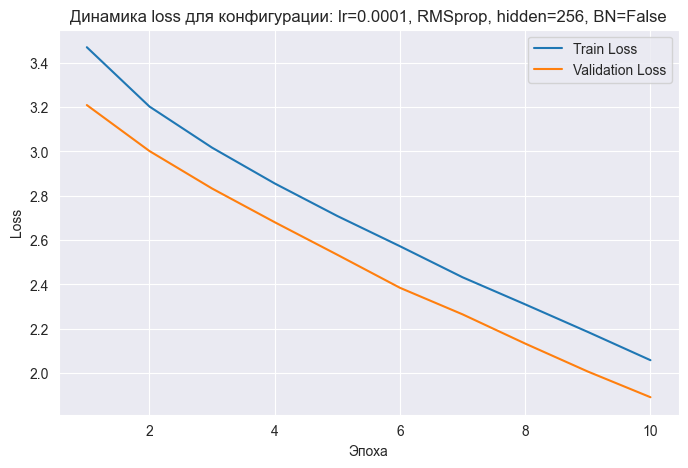

In [25]:
for config_to_plot in results:
    epochs = range(1, num_epochs_tune + 1)

    plt.figure(figsize=(8,5))
    plt.plot(epochs, config_to_plot['epoch_train_losses'], label='Train Loss')
    plt.plot(epochs, config_to_plot['epoch_val_losses'], label='Validation Loss')
    plt.xlabel('Эпоха')
    plt.ylabel('Loss')
    plt.title(f"Динамика loss для конфигурации: lr={config_to_plot['lr']}, {config_to_plot['optimizer']}, hidden={config_to_plot['hidden_size']}, BN={config_to_plot['batchnorm']}")
    plt.legend()
    plt.grid(True)
    plt.show()

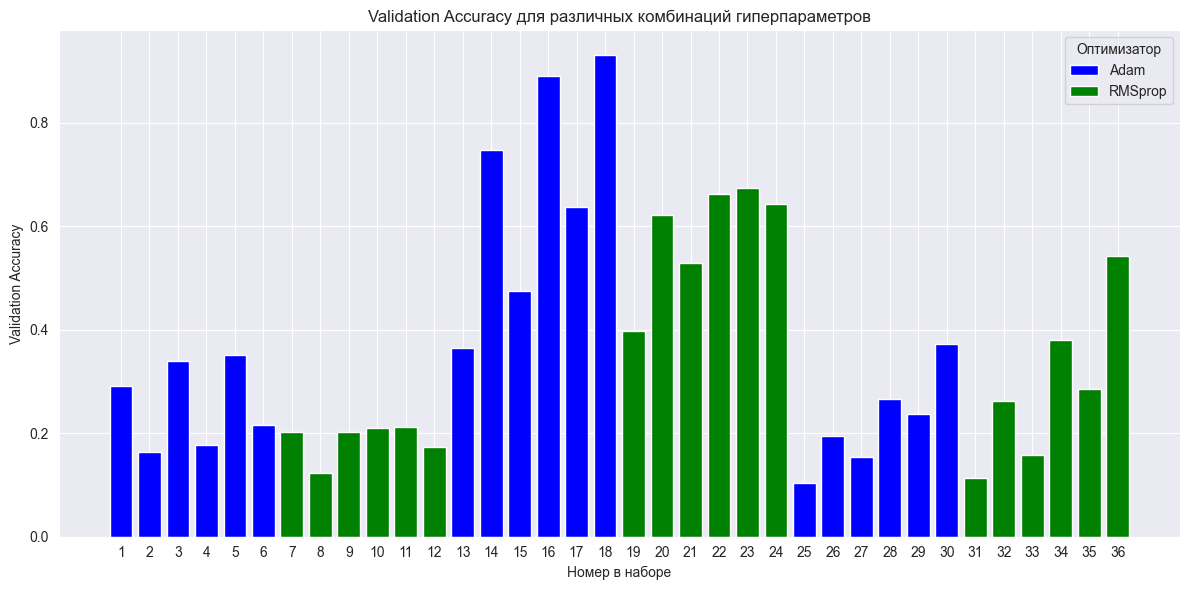

In [35]:
from matplotlib.patches import Patch
# Преобразуем список results в DataFrame, если он ещё не создан
results_df = pd.DataFrame(results)
results_df['config'] = results_df.apply(lambda row: f"lr={row['lr']}\n{row['optimizer']}\nhidden={row['hidden_size']}\nBN={row['batchnorm']}", axis=1)

# Задаём соответствие оптимизаторов и цветов
color_map = {
    'Adam': 'blue',
    'RMSprop': 'green',
}

# Присваиваем каждому результату цвет, используя цветовую карту; если оптимизатор не найден — серый
results_df['color'] = results_df['optimizer'].map(lambda x: color_map.get(x, 'gray'))

# Строим график: ось X — номер комбинации (без сортировки), ось Y — final_val_acc
plt.figure(figsize=(12,6))
bars = plt.bar(results_df.index + 1, results_df['final_val_acc'], color=results_df['color'])

plt.xlabel('Номер в наборе')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy для различных комбинаций гиперпараметров')
plt.xticks(results_df.index + 1)  # подписываем x-тики как 1,2,3,...

# Создаём легенду с помощью Patch для отображения соответствия цвета оптимизатора
legend_elements = [Patch(facecolor=col, label=opt) for opt, col in color_map.items()]
plt.legend(handles=legend_elements, title='Оптимизатор')

plt.tight_layout()
plt.show()

### Анализ
Из графиков видно, что при большом lr batch normalization критически влияет на результаты обучения. Без bn и большом lr модель просто застревает после 5 эпох на достаточно плохом результате, при включенном же bn она начинает уже с достаточно хорошего результата и продолжает его улучшать. При малом lr bn скорее вредит на данном тест сете. Больший размер hidden слоя ожидаемо помогает улучшить результаты. Наилучшие результаты при lr=0.001, а наилучший оптимизатор — Adam.

## Проверим модель на лучших гиперпараметрах
натренируем на 30 эпохах

In [ ]:
model = train_one_configuration(*best_config, num_epochs=30)['model']

model.eval()  # оцениваем в режиме infer
test_loss = 0.0
test_correct = 0
test_total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * X_batch.size(0)
        _, preds = outputs.max(1)
        test_correct += (preds == y_batch).sum().item()
        test_total += X_batch.size(0)
avg_test_loss = test_loss / test_total
test_accuracy = test_correct / test_total

In [37]:
print(f"Test Loss = {avg_test_loss:.4f}, Test Accuracy = {test_accuracy:.4f}")

Test Loss = 11.3804, Test Accuracy = 0.0826


Результаты — говно, но в 3 раза лучше чем рандом

# Результаты
- [x] Найти данные в виде изображений для задачи классификации — взят датасет оксфорда с животными
- [x] Реализовать классы, необходимые для построения сети со следующими слоями
	- FullyConnectedLayer
	- ReluLayer
	- FullyConnectedLayer
- [x] Использовать CrossEntropyLoss и L2-регуляризацию.
- [x] Обучить модель на тренировочных данных, подбирать параметры (особенно learning rate) на валидационной и оценить качество на тестовой. Анализировать графики train/val loss, проверять на каждом шаге корректность вычисления градиентов с помощью разностной оценки.
- [x] (**+2 балла**) Добавить Batch normalization.
- [x] (**+2 балла**) Взят оптимизатор RMSprop.
- [x] (**+1 балл**) Реализован и использован оптимизатор Adam.